# Practical 2: Q-learning and Maximum Likelihood estimation

In this practical, we will explore the inner workings of the Q-learning model, as it is used in cognitive neuroscience. Using this model, we will also try out things like grid-search and minimizer-based fitting. 

The Q-learning model (and the experiments inspired by it) has allowed researchers to relate specific abstract (latent) components of the learning and decision-making processes to specific brain mechanisms. In the exapmle in the lecture we saw that specific parameters were changed as a results of Parkinson's disease, and that only one of these parameters turned out to be influenced by dopaminergic medication - the other was affected by disease status but influenced not by medication. These separate factors could then be related to Blood Oxygenation Level Dependent (BOLD) signals measured using fMRI. This type of research, and the deep insight we gain from it, is made possible by the use of **Neural Models of Cognitive Processes**!

This practical has more supporting code than the previous practical. Feel free to browse around in the code, but it's not necessary to understand all of it. I just left it in the notebook for your perusal. The supporting code encapsulates the simulations of an experiment and the Q-learning behavior evoked by the experiment in the class **`Simulate_QLearn`**. Furthermore, we provide a function that returns the negative log-likelihood of a dataset given a specific set of model parameters (**`RL_train_NLL`**).



In [1]:
import math
import scipy as sp
import scipy.stats as stats 
import numpy as np
import matplotlib 
import matplotlib.pylab as plt
import pandas as pd
import itertools as it
import scipy.optimize as op

#### Provenance notice

This code was taken, with minor adaptations, from the implementation by J Van Slooten, https://osf.io/qy4v7/

For more information, see: 
Slooten, J., Jahfari, S., Knapen, T., Theeuwes, J. (2018). How pupil responses track value-based decision-making during and after reinforcement learning. PLOS COMPUTATIONAL BIOLOGY  14(11), e1006632. https://dx.doi.org/10.1371/journal.pcbi.1006632

Note that this work used a hierarchical Bayesian fitting procedure, and we'll focus on the MLE version of the fitting here. 

In [2]:
class Simulate_QLearn(object): 
    """Simulate choice data using Q-learning algorithm(s) """ 
    
    def __init__(self, beta, alphaG, alphaL, epsilon=1e-6, tau=0):

        #Original Q-learning model with two learning rates and inverse temp param
        self.beta   = beta
        self.alphaG = alphaG
        self.alphaL = alphaL
        # parameters that are in the model but not to be fitted here...
        self.epsilon= epsilon  # forgetting rate
        self.tau = tau            # discounting rate

    def generate_experiment(self, run_count=3, n_reps_per_run=20): 
        """generate an experimental set of trials to use in simulate_RL_train """
        
        runs=[]

        ##### SIMULATE TRIALS #####
        # make simulation trials of choice options and reward -->6 runs of 60 trials 
        good = np.repeat([0,2,4], n_reps_per_run) #80,70,60
        bad  = np.repeat([1,3,5], n_reps_per_run) #20,30,40

        # good and bad choice reward probabilities --> reward=0, no reward=1
        good_prob = list(zip([16,14,12], [4,6,8]))
        r_g = np.concatenate([np.concatenate([np.zeros(good_prob[x][0]),
                                np.ones(good_prob[x][1])]) for x in range(len(good_prob))])
        r_b = 1-r_g 

        # simulated trial types per run 
        run = pd.DataFrame(np.array([good, bad, r_g, r_b]).T, columns=['good','bad', 'r_g', 'r_b'])
            
        # shuffle and append runs 
        
        for i in range(run_count):
            runs.append(run.sample(frac=1).reset_index(drop=True))
        
        # merge runs to one simulated session
        self.sim_session = pd.concat(runs, ignore_index=True)

    def simulate_RL_train(self): 
        """ simulate choices using the original Q-learning algorithm """
        
        if not hasattr(self, 'sim_session'): # need to generate trials
            self.generate_experiment()
            
        data = self.sim_session

        #####  VARIABLES #####
        choices = np.array(data['good']).astype(int)
        reward = data[['r_g', 'r_b']].astype(int) # 0=reward, 1=noreward
        
        prQ = np.repeat(0.5,6)
        correct = np.zeros(choices.shape[0]).astype(int)
        selection = np.zeros(choices.shape[0])
        q_chosen_sim = np.zeros(choices.shape[0])
        q_unchosen_sim = np.zeros(choices.shape[0])
        rpe_sim = np.zeros(choices.shape[0])
        r=np.zeros(choices.shape[0])
        all_Qvalues = np.zeros((6, choices.shape[0]))
        QChoices = np.zeros((len(choices),2))  

        #-----------------------------------------------------------------------#
        # 				Simulate choices and choice probabilities 				#
        #-----------------------------------------------------------------------#

        for tr in range(choices.shape[0]): 

            #Qvalues stimulus pair
            QChoice = [prQ[choices[tr]], prQ[choices[tr]+1]] 
            QChoices[tr]=QChoice
                    
            #Choice probabilities stimulus pair
            pChoice = 1/(1+np.exp(self.beta*(QChoice[1]-QChoice[0])))
            pChoice = np.array([pChoice, 1-pChoice]) 									
            pChoice = self.epsilon/2+(1-self.epsilon)*pChoice 

            #simulate choices based on stim choice probabilities 
            if tr == 0: 
                correct[tr] = np.random.multinomial(1, [0.5,0.5])[0]
            else: 
                correct[tr] = np.random.multinomial(1, pChoice)[0]

            #the simulated choice given the model; 0 is correct choice 
            simChoice=1-correct[tr] 

            #choice prob. given the model
            selection[tr]=pChoice[simChoice]
            
            #the q-value of the simulated chosen and unchosen stimulus, before updating
            q_chosen_sim[tr]=prQ[choices[tr]+simChoice]
            q_unchosen_sim[tr]=prQ[choices[tr]+1-simChoice]

            #positive learning rate
            if (simChoice==0 and reward['r_g'][tr]==0) or (simChoice==1 and reward['r_b'][tr]==0): 
                alpha = self.alphaG
            #negative learning rate 
            elif (simChoice==0 and reward['r_g'][tr]==1) or (simChoice==1 and reward['r_b'][tr]==1):
                alpha = self.alphaL
            else: 
                print('wrong reinforcement')

            #reinforcement associated with simChoice  
            if simChoice == 0: 
                r[tr]=1-reward['r_g'][tr] #r=1, reward
            else: 
                r[tr]=1-reward['r_b'][tr] #r=0, no reward

            #calculate simulated rpe 
            rpe_sim[tr] = r[tr]-prQ[choices[tr]+simChoice]

            #update stimulus Q-value 
            prQ[choices[tr]+simChoice] = prQ[choices[tr]+simChoice] \
                                            + alpha*(r[tr]-prQ[choices[tr]+simChoice])

            #decay values to initial value 
            prQ = prQ + self.tau * (0.5-prQ)
            all_Qvalues[:,tr]=prQ		
        
        #simulated results, correct simulated choice=1/incorrect=0; rewarded simulated choice=1/noreward=0
        sim_results = pd.DataFrame(np.array([choices, correct, r, selection, q_chosen_sim, 
            q_unchosen_sim, rpe_sim, QChoices[:,0]-QChoices[:,1]]).T, 
            columns=['stim_pair', 'correct_sim','reward_sim', 'select_prob_sim', 'q_chosen_sim', 
            'q_unchosen_sim', 'rpe_sim', 'qdiff_sim'])
        sim_Qvals = pd.DataFrame(np.array(all_Qvalues.T), 
            columns=['sA','sB','sC','sD','sE','sF'])
        self.sim_results = pd.concat([sim_results, sim_Qvals], axis=1)
    
    def plot_simulation(self, data_types=['qdiff_sim', 'rpe_sim'], pairs=[0,2,4], new=False):
        """
        plot the simulated timecourses of `data_types` of a full experiment, for the given pairs. 
        """
        if not hasattr(self, 'sim_results') or new:
            self.generate_experiment()
            self.simulate_RL_train()
        to_be_plotted = [self.sim_results[data_types][self.sim_results['stim_pair']==x] for x in pairs]
        f, ss = plt.subplots(1, len(pairs), figsize=(len(pairs)*6,4), sharey=True)
        ss[0].set_ylabel('Difference in Q-value between choice options\n&\nReward prediction error')
        for i, tbp in enumerate(to_be_plotted):
            tbp.plot(ax=ss[i])
            ss[i].set_title('pair ' + str(pairs[i]))
            ss[i].set_xlabel('trial #')
                            
    def plot_decision_function(self, f=False, line='r:', label=''):
        if not f:
            f = plt.figure()
        plt.plot(np.linspace(-1,1,100), 1/(1+np.exp(self.beta*(np.linspace(-1,1,100)))), line, label=label)
        plt.ylabel('p(incorrect)')
        plt.xlabel('$\Delta$ value between chosen and not-chosen stimulus')
        plt.axvline(0, lw=0.5, color='k')
        

def RL_train_NLL(theta, data): 
    """ Returns the negative log likelihood of the data given the values of theta.
    In this implementation, we fit beta, alpha gain and alpha loss, but not the forgetting and discounting rates."""	

    #parameters to fit
    beta = theta[0] * 100       # inverse gain recoded to [0-100]
    alphaG = theta[1]           # learning rate gain
    alphaL = theta[2]           # learning rate loss
    epsilon = 1e-5 			    # forgetting rate
    tau = 0 					# discounting	

    choices = np.array(data['stim_pair']).astype(int)       #recode into 0,2,4 integers - used for indexing	
    correct = 1-np.copy(data['correct_sim']).astype(int)    #0=correct,1=incorrect -> recoded/reversed to be able to fit. 
    reward = 1-np.copy(data['reward_sim']).astype(int)      #0=reward,1=noreward -> recoded/reversed to be able to fit.

    #start Q-values
    prQ0 = np.repeat(0.5,6) 
    prQ = prQ0

    #initialise Qvalue, probs & prediction error arrays
    QChoices = np.zeros((len(choices),2))  
    selection = np.zeros(len(choices))

    #loop over trials
    for tr in range(choices.shape[0]): 

        #calculate choice prob using soft max
        QChoice = [prQ[choices[tr]], prQ[choices[tr]+1]] 	#Qvalues of stimulus pair
        QChoices[tr]=QChoice

        pChoice = 1/(1+np.exp(beta*(QChoice[1]-QChoice[0])))
        pChoice = np.array([pChoice, 1-pChoice]) 									
        pChoice = epsilon/2+(1-epsilon)*pChoice 	#choice probs of stimulus pair

        selection[tr] = pChoice[correct[tr]]  	    #probability of the chosen stimulus

        #select correct learning rate
        if reward[tr] == 0: 
            alpha = alphaG
        elif reward[tr]==1: 
            alpha = alphaL

        #update stimulus Q-value
        r=1-reward[tr] #1 or 0 			
        
        # update
        prQ[choices[tr]+correct[tr]] = prQ[choices[tr]+correct[tr]] \
                                    + alpha*(r-prQ[choices[tr]+correct[tr]])

        #decay Q-values toward initial value
        prQ=prQ+tau*(0.5-prQ)

    #log likelihood 
    loglik = sum(np.log(selection)) 

    #correct for funny values
    if math.isnan(loglik): 
        loglik = -1e15  
        print('LLH is nan')
    if loglik == float("inf"):
        loglik = 1e15   
        print('LLH is inf')

    return -loglik

# Simulation of an experiment


The cells below exemplify how to simulate an experiment and the associated choices and learning given specific values of the explore/expoit and positive/negative learning rate parameters. 

***NOTE:*** We'll be simulating experiments all the time, so you can always go back to these plots, if you want to see what actual behavior did during the experiment.

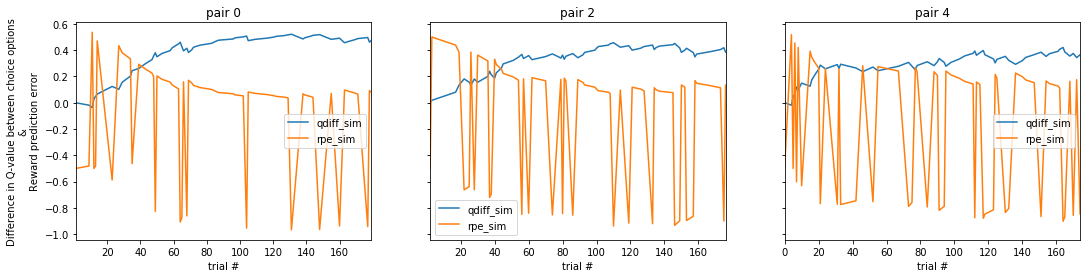

In [3]:
# first, what are my parameters?
beta_sim = 22.4
ag_sim = 0.123
al_sim = 0.037

sql = Simulate_QLearn(beta=beta_sim, alphaG=ag_sim, alphaL=al_sim)
sql.plot_simulation()

Damn, that was easy! A whole synthetic experiment, just like that! 

The `sql.sim_results` variable (a pandas `DataFrame`) contains all of the information about the simulation. Feel free to explore what's in there by looking inside (just run `sql.sim_results` in a code cell, you'll see the entire table).  

### Question 1: 
Try to run it a couple of times with the same parameters settings - describe what aspects of the experiment change, and which don't. 

**HINT:** In the lecture, I explained that each parameter setting of the model maps onto a probability distribution over datasets. How does what you're seeing here relate to that statement?

### Question 2: 
Try to change the parameters a bit - describe what happens for changes up and down for each of the parameters. Oh, and look how easy it is to make nice symbols in markdown cells!

- $\alpha_{gain}:$
- $\alpha_{loss}:$
- $\beta:$

#### there's a little function that plots the decision-making function used in the simulation.


,stim_pair,correct_sim,reward_sim,select_prob_sim,q_chosen_sim,q_unchosen_sim,rpe_sim,qdiff_sim,sA,sB,sC,sD,sE,sF
0,4.0,1.0,0.0,0.500000,0.500000,0.500000,-0.500000,0.000000,0.500000,0.500000,0.500000,0.5000,0.481500,0.5000
1,0.0,1.0,0.0,0.500000,0.500000,0.500000,-0.500000,0.000000,0.481500,0.500000,0.500000,0.5000,0.481500,0.5000
2,2.0,0.0,0.0,0.500000,0.500000,0.500000,-0.500000,0.000000,0.481500,0.500000,0.500000,0.4815,0.481500,0.5000
3,2.0,1.0,1.0,0.602142,0.500000,0.481500,0.500000,0.018500,0.481500,0.500000,0.561500,0.4815,0.481500,0.5000
4,4.0,1.0,1.0,0.397858,0.481500,0.500000,0.518500,-0.018500,0.481500,0.500000,0.561500,0.4815,0.545276,0.5000
5,4.0,0.0,0.0,0.266165,0.500000,0.545276,-0.500000,0.045276,0.481500,0.500000,0.561500,0.4815,0.545276,0.4815
6,4.0,1.0,1.0,0.806678,0.545276,0.481500,0.454724,0.063776,0.481500,0.500000,0.561500,0.4815,0.601207,0.4815
7,4.0,1.0,0.0,0.935921,0.601207,0.481500,-0.601207,0.119707,0.481500,0.500000,0.561500,0.4815,0.578962,0.4815
8,4.0,1.0,1.0,0.898726,0.578962,0.481500,0.421038,0.097462,0.481500,0.500000,0.561500,0.4815,0.630750,0.4815
9,0.0,1.0,0.0,0.397858,0.481500,0.500000,-0.481500,-0.018500,0.463684,0.500000,0.561500,0.4815,0.630750,0.4815


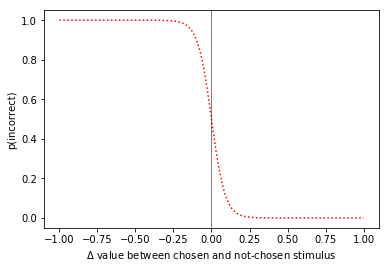

In [4]:
sql.plot_decision_function()
sql.sim_results.head(90)

### Question 3: 

Let's use this plotting function to explore what different values of $\beta$ do. Change the code in the cell below to explore this. Try to relate the results to your answer in **Question 2**.

In [5]:
beta_values = [FILL STUFF IN HERE]
linestyles = ['r--', 'g--', 'b--', 'k--', 'm--', 'c--', 'y--', 'r:', 'g:', 'b:', 'k:', 'm:', 'c:', 'y:'] 

f = plt.figure(figsize=(12,5))
for beta, linestyle in zip(beta_values, linestyles):
    sql = Simulate_QLearn(beta=beta, alphaG=0, alphaL=0)
    sql.plot_decision_function(f=f, line=linestyle, label=str(beta))
plt.legend();

SyntaxError: invalid syntax (<ipython-input-5-09928c63acf9>, line 1)

# Likelihood (or rather, negative log-likelihood)

We also have a function (**`RL_train_NLL`**) to return the negative log-likelihood of the model given a (simulated or real) dataset. 

Let's try that out. 

### Please note 

In the simulations, $\beta$ ranges from 0 to >100, because of how it's defined in the equations. But, for the NLL function and the fitting, we'll scale beta to remain in the $[0,1]$ range by dividing it by 100. This is because the fitting procedure will then be able to take similar steps in the $\beta$, $\alpha_{gain}$ and $\alpha_{loss}$ parameter spaces. 


In [6]:
# first, what are my parameters?
beta_sim = 22.4
ag_sim = 0.23
al_sim = 0.123

sql = Simulate_QLearn(beta=beta_sim, alphaG=ag_sim, alphaL=al_sim)
# if we're not plotting, we'll need to run the stimulation ourselves.
sql.simulate_RL_train()

# But, what's the negative log-likelihood of this data given a few parameters?

##########################################################################################################
###
### See the note on beta scaling above
###
##########################################################################################################

beta_test = 0.05
ag_test = 0.3
al_test = 0.04

nll = RL_train_NLL(theta=[beta_test, ag_test, al_test], data=sql.sim_results)

print(f'Negative log-likelihood is {nll}')

Negative log-likelihood is 37.131500564719566


### Question 4:

Try to vary the parameters around, but keep the dataset the same - this means you shouldn't run the simulation again! So, use a separate (new code cell).

What happens when the test parameters come closer to the simulation parameters? And when they move away from the simulation parameters?

In [7]:
# code cell

### Question 5:

Well, that's all nice and good but that's not fitting anything, its it? Let's get the computer to do the work for us. 

First, we'll try a **grid search** in a 2D parameter plane, across the alphas. ***Your assignment:*** Plot the likelihood landscape for three different simulated experiments, for different parameters. Use the title of the plot to make it clear what plot belongs to what simulation. 

## BONUS:

In **Question 5** I'm fixing $\beta$, but you could also fix one of the alphas. This will force you to think about the range of beta so be sure you understand the note above.... 

So, the assignment is to write code that creates and plots a likelhood landscape across $\beta$ and some $\alpha$ of your choosing, and use it for the data that came from your third simulation of **Question 5**. Make sure you label the plot correctly!

Remember, this is a BONUS question for a reason! First do the further questions...

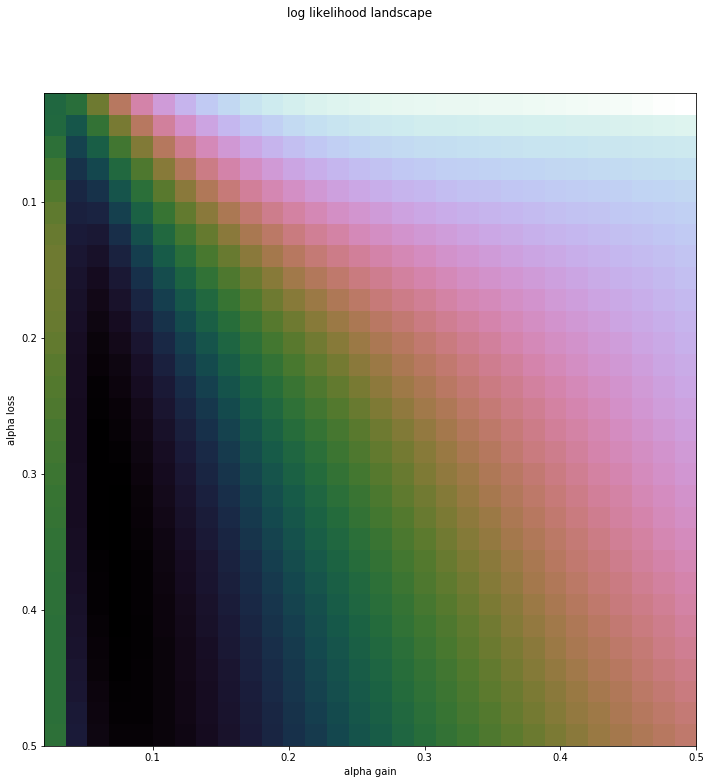

In [15]:
# we're still working with the same data. 

n_grid_steps = 30
fixed_beta = 0.2
alpha_range = np.linspace(0.02, 0.5, n_grid_steps)

ag, al = np.meshgrid(alpha_range, alpha_range) # you can always look up what np.meshgrid does...

# let's for loop across the calculations
nlls = np.zeros((n_grid_steps, n_grid_steps))
for x in range(n_grid_steps):
    for y in range(n_grid_steps):
        # pick the parameters for this specific NLL calculation
        theta = [fixed_beta, ag[x,y], al[x,y]]
        nlls[x,y] = RL_train_NLL(theta=theta, data=sql.sim_results)
        
# and plot the result - as log likelihood in this case. 
f = plt.figure(figsize=(12,12))
plt.imshow(nlls, 
           cmap='cubehelix', 
           aspect='equal', 
           extent=[alpha_range[0], alpha_range[-1], alpha_range[-1], alpha_range[0]])
f.suptitle('log likelihood landscape')
f.gca().set_xlabel('alpha gain')
f.gca().set_ylabel('alpha loss');

# Fitting the Q-learning model

It's good that we have the tools to investigate the parameter landscape of your model. But if we have data, we can also have the computer find the minimum itself. Let's try that out.  

We'll

1. simulate an experiment with a random set of parameters
2. fit the model using `scipy`'s `minimize` functionality

Check the correspondence between the two. 

In [9]:
# create random parameters
beta_sim, ag_sim, al_sim = np.random.rand()*40, np.random.rand()*0.4, np.random.rand()*0.4
# simulate model
sql = Simulate_QLearn(beta=beta_sim, alphaG=ag_sim, alphaL=al_sim)
# if we're not plotting, we'll need to run the stimulation ourselves.
sql.simulate_RL_train()

fit_result = op.minimize(fun=RL_train_NLL, 
            x0=(0.2, 0.2, 0.2), 
            method='SLSQP',# 'CG',#'L-BFGS-B', 
            args=(sql.sim_results, ), 
            bounds= ((1e-6,10), (1e-6,1), (1e-6,1),))
print(fit_result)

beta_fit, ag_fit, al_fit = fit_result['x']

print(f"beta_sim:{beta_sim} vs beta_fit:{beta_fit*100}")
print(f"ag_sim:{ag_sim} vs ag_fit:{ag_fit}")
print(f"al_sim:{al_sim} vs al_fit:{al_fit}")

     fun: 20.14999926300357
     jac: array([0.00562859, 0.00138044, 0.00323725])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.1154457 , 0.52881203, 0.23623882])
beta_sim:14.840190119919466 vs beta_fit:11.544569748961386
ag_sim:0.36964382195815454 vs ag_fit:0.5288120323221974
al_sim:0.22175673287896563 vs al_fit:0.2362388173160367


### Question 6:

Run the above code a couple of times. Explain what you see. Is the fit perfect?

Change the code (in separate cells, of course - and with comments and markdown explanations where necessary) to try to:

- Fit the same simulation twice: Are the results the same?
- Simulate the experiment again, but with the same parameters. Then, re-fit. Are the results the same?

Interpret these results.

# Parameter recovery.

How do we even know whether our fits will deliver sensible results? It could be that for certain parameter combinations, it becomes impossible to retrieve parameters correctly. Parameter recovery was explained in the lecture, so we'll follow that recipe.
We'll 

- do the following a 100 times:
    1. simulate an experiment
    2. fit the model using `scipy`'s `minimize` functionality
    3. save the results

Then, we'll check the correspondence between the simulated inputs and fitted outputs. 

In [10]:
sims = []
for x in range(100):
    beta_sim, ag_sim, al_sim = np.random.rand()*40, np.random.rand()*0.4, np.random.rand()*0.4
    sql = Simulate_QLearn(beta=beta_sim, alphaG=ag_sim, alphaL=al_sim)
    # sql.plot_simulation()
    # sql.plot_decision_function()
#     sql.generate_experiment()
    sql.simulate_RL_train()

    beta, alphaG, alphaL = op.minimize(fun=RL_train_NLL, 
                x0=(0.2, 0.2, 0.2), 
                method='L-BFGS-B', 
                args=(sql.sim_results, ), 
                bounds= ((1e-6,10), (1e-6,1), (1e-6,1),))['x']

    sims.append([beta_sim, ag_sim, al_sim, beta, alphaG, alphaL])
sims = np.array(sims)

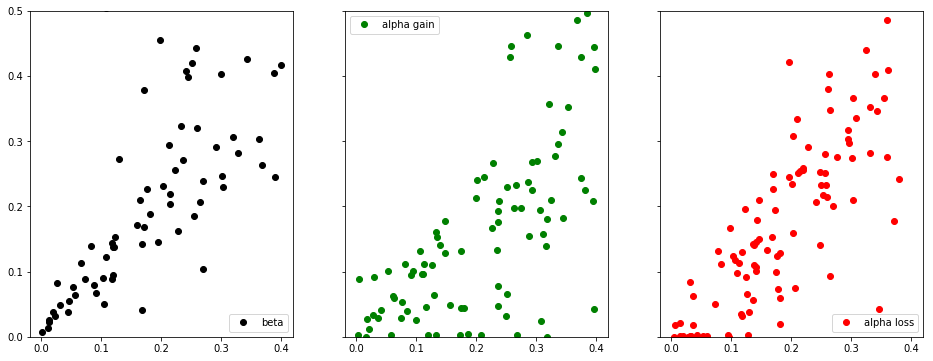

In [11]:
f, ss = plt.subplots(1, 3, figsize=(16,6), sharex=True, sharey=True)
ss[0].plot(sims[:,0]/100, sims[:,3], 'ko', label='beta')
ss[0].legend()
ss[1].plot(sims[:,1], sims[:,4], 'go', label='alpha gain')
ss[1].legend()
ss[2].plot(sims[:,2], sims[:,5], 'ro', label='alpha loss')
ss[2].set_ylim([0,0.5]);
ss[2].legend()

### Question 7:

- How could you see whether you can recover the parameters in the above plot?
- Inspect the bounds of the fitting routing. I sneakily changed the limits of the plot. Comment the line that limits the y scale, and re-plot the parameter recovery plots. What do you see? Is there any sign of instability?
- Right now, we're using a *HUGE* range for the parameters. What happens when you limit the simulations to a more narrow set of ranges, say:

    - $\beta: [0.5,10]$
    - $\alpha_{gain}: [0.05,0.25]$
    - $\alpha_{loss}: [0.0125,0.15]$    
    
Are the parameters stable now? What does this mean about the importance of knowing what your parameters mean?
